In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso

In [2]:
df = pd.read_csv('../data/division_offences_by_seifa_indexes.csv')


In [3]:
# Drop rows with missing values
df_clean = df.dropna()
df = df_clean.copy()

In [4]:
# Crime columns list
crime_cols = ['Violent Crime', 'Property Crime', 'Drug Offences',
              'DV-Related', 'Other Crimes', 'Total Crimes']

# deciles columns
deciles = ['IRSD Decile', 'IER Decile', 'IEO Decile']

In [5]:
#for col in crime_cols:
#    df[col] = np.log1p(df[col])

df[crime_cols] = df[crime_cols] / 100


In [6]:

# Group by all deciles and calculate mean and sum for each crime type
grouped = df.groupby('IRSD Decile')['Violent Crime'].agg(['mean', 'sum']).reset_index()

# Display the result
grouped


,IRSD Decile,mean,sum
0,1,1499.593087,115468.667664
1,2,639.919239,25596.769564
2,3,572.186311,15449.030392
3,4,760.612617,12169.801868
4,5,877.952012,23704.704317
5,6,601.512016,8421.168219
6,7,630.618245,8198.037187
7,8,428.490962,3427.927699
8,9,639.838903,5758.550125
9,10,1845.559826,7382.239305


In [7]:

# Group by the deciles and calculate sum and mean of Violent Crime
grouped = df.groupby(['IRSD Decile', 'IER Decile', 'IEO Decile']).agg({'DV-Related': ['sum', 'mean']}).reset_index()

# Reshape the dataframe to have 'Violent Crime_sum' and 'Violent Crime_mean' as columns
grouped.columns = ['IRSD Decile', 'IER Decile', 'IEO Decile', 'DV-Related Sum', 'DV-Related Mean']

# Group by the different index columns and calculate the mean for 'DV-Related'
means = df.groupby(['IRSD Decile'])['DV-Related'].mean().reset_index()

# If you want just the mean for each index (IRSD, IER, IEO) as a summary, you can do it without breaking by decile
mean_irsd = df['DV-Related'].mean()  # Mean for IRSD as a whole

print(f"Mean of DV-Related for IRSD: {mean_irsd}")



Mean of DV-Related for IRSD: 261.5515634146343


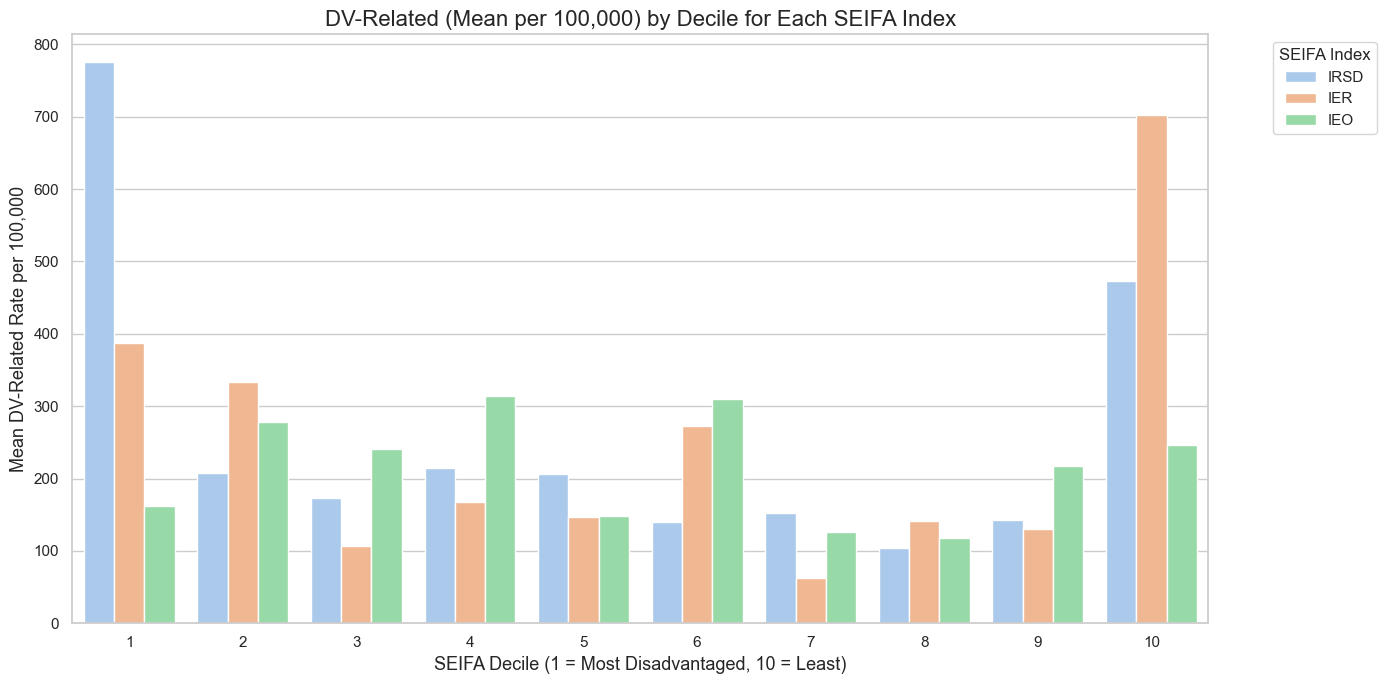

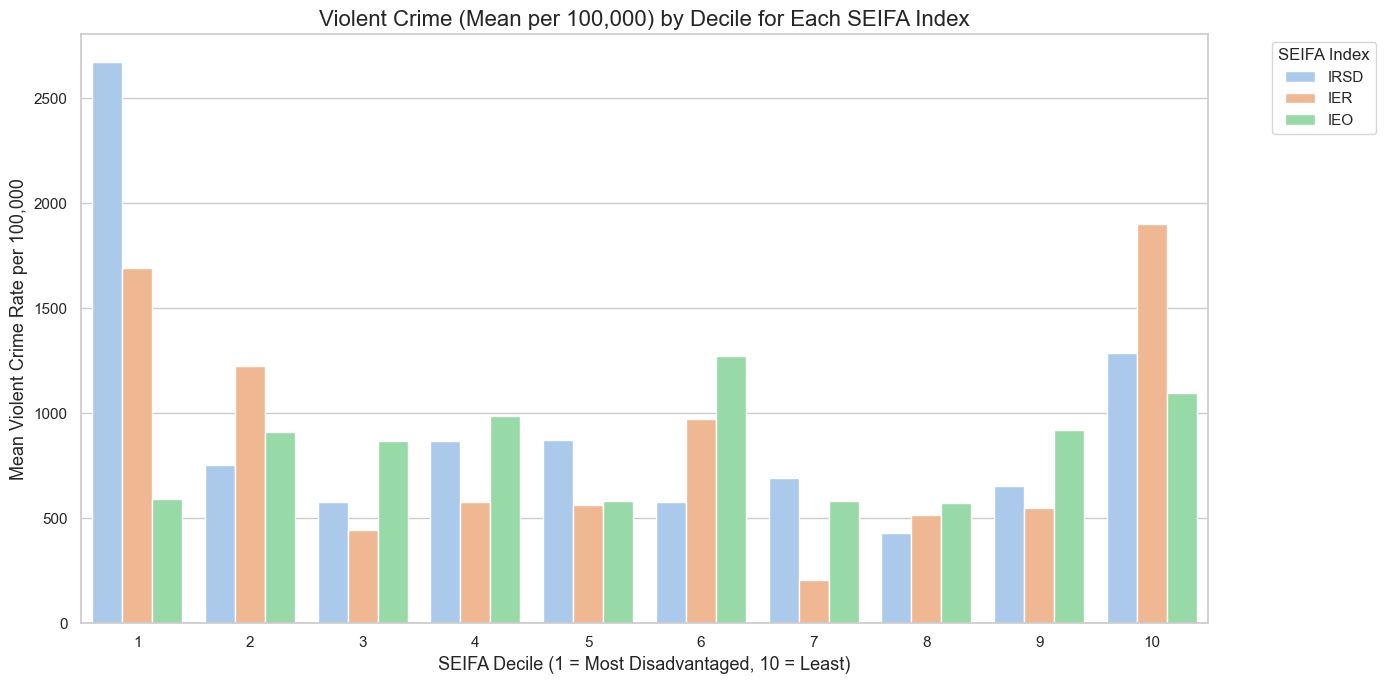

In [8]:
# Set style
sns.set_theme(style="whitegrid")

# List of crime types
crime_types = ['DV-Related', 'Violent Crime']

# Label mapping
index_labels = {
    'IRSD Decile': 'IRSD',
    'IER Decile': 'IER',
    'IEO Decile': 'IEO'
}

# Plot each crime type
for crime in crime_types:
    # Group and calculate mean
    grouped = df.groupby(['IRSD Decile', 'IER Decile', 'IEO Decile'])[crime].mean().reset_index()

    # Melt to long format
    df_long = pd.melt(
        grouped,
        id_vars=[crime],
        var_name='Index Type',
        value_name='Decile'
    )
    df_long['Crime'] = crime
    df_long.rename(columns={crime: 'Mean Value'}, inplace=True)
    df_long['Index Label'] = df_long['Index Type'].map(index_labels)
    df_long['Decile'] = df_long['Decile'].astype(int)

    # Sort for plotting
    df_long = df_long.sort_values(by='Decile')

    # Plot
    plt.figure(figsize=(14, 7))
    barplot = sns.barplot(
        data=df_long,
        x='Decile',
        y='Mean Value',
        hue='Index Label',
        palette='pastel',
        errorbar=None
    )
    
    # Title and axes
    plt.title(f'{crime} (Mean per 100,000) by Decile for Each SEIFA Index', fontsize=16)
    plt.xlabel('SEIFA Decile (1 = Most Disadvantaged, 10 = Least)', fontsize=13)
    plt.ylabel(f'Mean {crime} Rate per 100,000', fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Move legend outside
    plt.legend(title='SEIFA Index', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)

    plt.tight_layout()
    plt.show()


C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\444440598.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IRSD Decile', y='log_DV_Crime', data=df, palette='pastel')


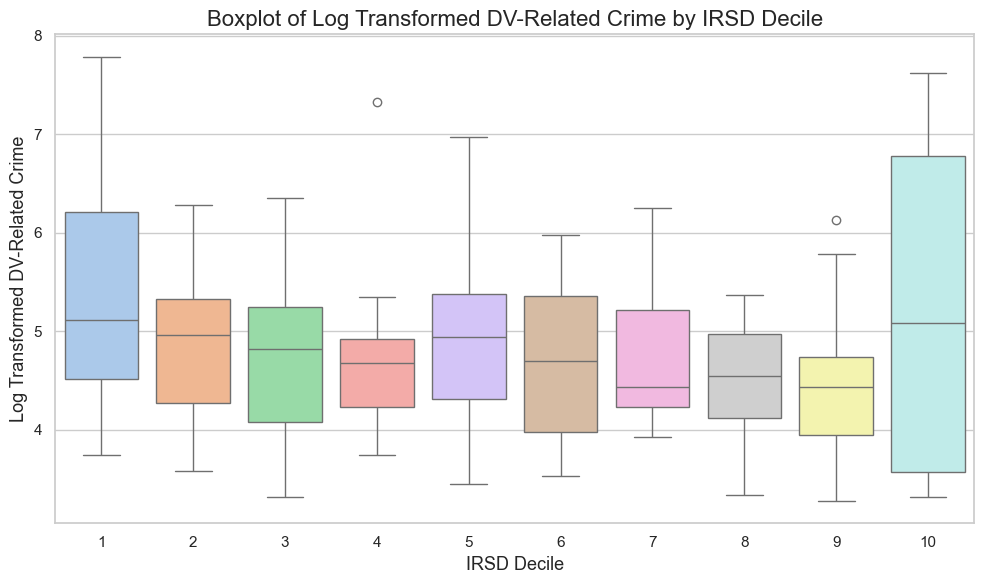

In [9]:
# the spikes seem to be in the 1st decile for IRSD and 10th decile for IER.
# Although it is not clear if the spikes are due to the data or the plotting method.
# Check for outliers in the IRSD Decile

#let's log transform the data to reduce the effect of outliers
df['log_DV_Crime'] = np.log1p(df['DV-Related'])  # log(1 + x) handles zero values safely
df['log_Violent_Crime'] = np.log1p(df['Violent Crime'])  # log(1 + x) handles zero values safely

# plot the log transformed data in a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='IRSD Decile', y='log_DV_Crime', data=df, palette='pastel')
plt.title('Boxplot of Log Transformed DV-Related Crime by IRSD Decile', fontsize=16)
plt.xlabel('IRSD Decile', fontsize=13)
plt.ylabel('Log Transformed DV-Related Crime', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [10]:
# it seems that the data from the 10th decile is way too variable 
# let's check the data for the 10th decile
df_10th_decile = df[df['IRSD Decile'] == 10]
print(df_10th_decile)

          Division  Violent Crime  Property Crime  Drug Offences   DV-Related  \
2     Albany Creek     208.910589     1166.066524     159.047910    37.778456   
96          Hendra    2610.500611    23739.723240    3612.128612   666.870167   
159  Mount Ommaney    4443.068318    18146.224531    2549.740312  2037.554934   
213        The Gap     119.759788     1007.679871     168.495207    26.677445   

     Other Crimes  Total Crimes   IRSD Score  IRSD Decile  IRSDA Score  \
2      499.542264   2071.345743  1086.676675           10  1068.768212   
96    7928.367928  38557.590558  1104.983298           10  1142.701375   
159   8692.768678  35869.356772  1091.324183           10  1107.814214   
213    344.959002   1667.571313  1093.496228           10  1108.933492   

     IRSDA Decile    IER Score  IER Decile    IEO Score  IEO Decile  \
2               9  1090.198282           9  1047.041146           9   
96             10  1109.376117          10  1126.899302          10   
159       

In [11]:
# It looks like the 10th decile has just a few rows with very high variability in crime rates.
# changing the approach to group the data by indexes 'groups' instead of the general deciles.
# that way we can see the data in a more granular way.

# Create 4 IRSD groups (quartiles)
# Note: pd.qcut automatically handles ties by assigning the same quantile to tied values
# and ensures that each group has an equal number of observations.
df['IRSD Group'] = pd.qcut(df['IRSD Score'], q=4, labels=[1, 2, 3, 4])
# same for IER and IEO groups
df['IER Group'] = pd.qcut(df['IER Score'], q=4, labels=[1, 2, 3, 4])
df['IEO Group'] = pd.qcut(df['IEO Score'], q=4, labels=[1, 2, 3, 4])

# Check the range within each group
range_by_group = df.groupby('IRSD Group')['IRSD Score'].agg(['min', 'max', 'count'])
print(range_by_group)

check = df.groupby(['IRSD Group'])['Usual Resident Population'].sum().reset_index()
check

                    min          max  count
IRSD Group                                 
1            492.476114   881.466109     59
2            886.764539   951.835070     59
3            953.895234  1008.211238     58
4           1008.383234  1104.983298     59


C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\3691084413.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_by_group = df.groupby('IRSD Group')['IRSD Score'].agg(['min', 'max', 'count'])
C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\3691084413.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  check = df.groupby(['IRSD Group'])['Usual Resident Population'].sum().reset_index()


,IRSD Group,Usual Resident Population
0,1,188510
1,2,260677
2,3,405415
3,4,513142


C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\3015128859.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['IRSD Group', 'IER Group', 'IEO Group'])[crime].mean().reset_index()


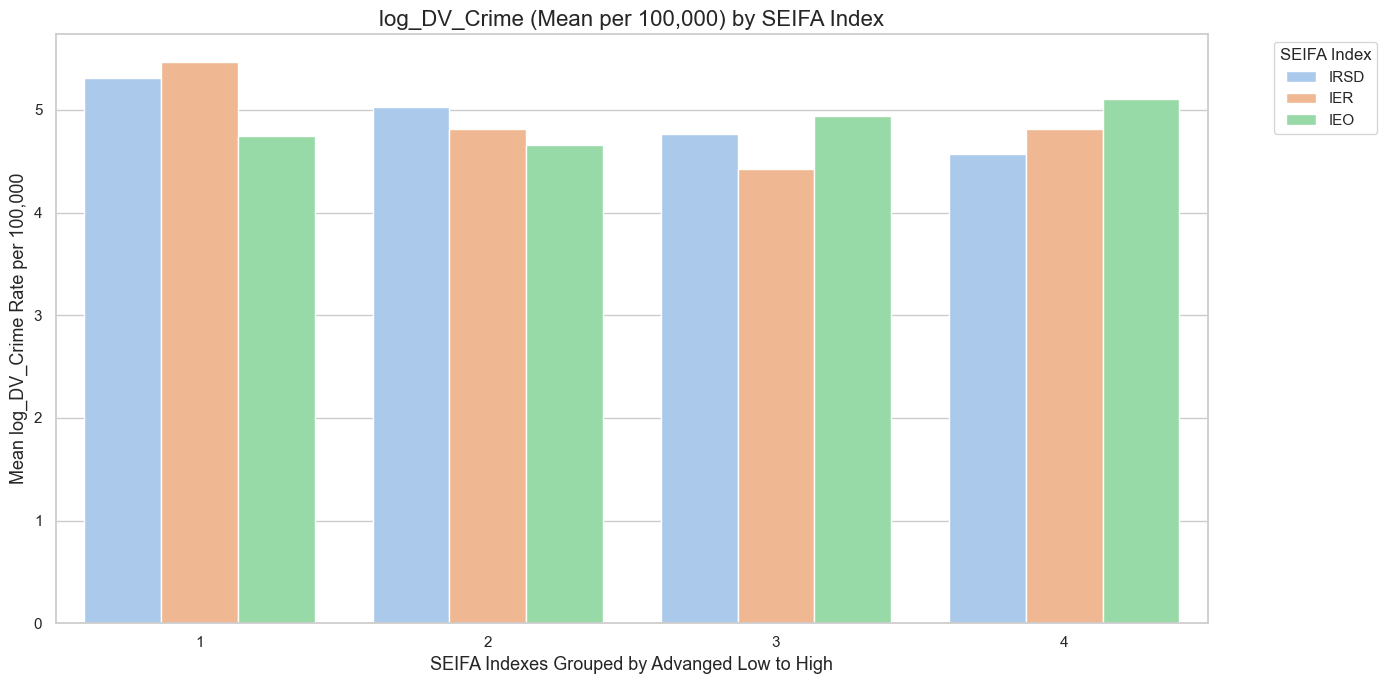

C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\3015128859.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['IRSD Group', 'IER Group', 'IEO Group'])[crime].mean().reset_index()


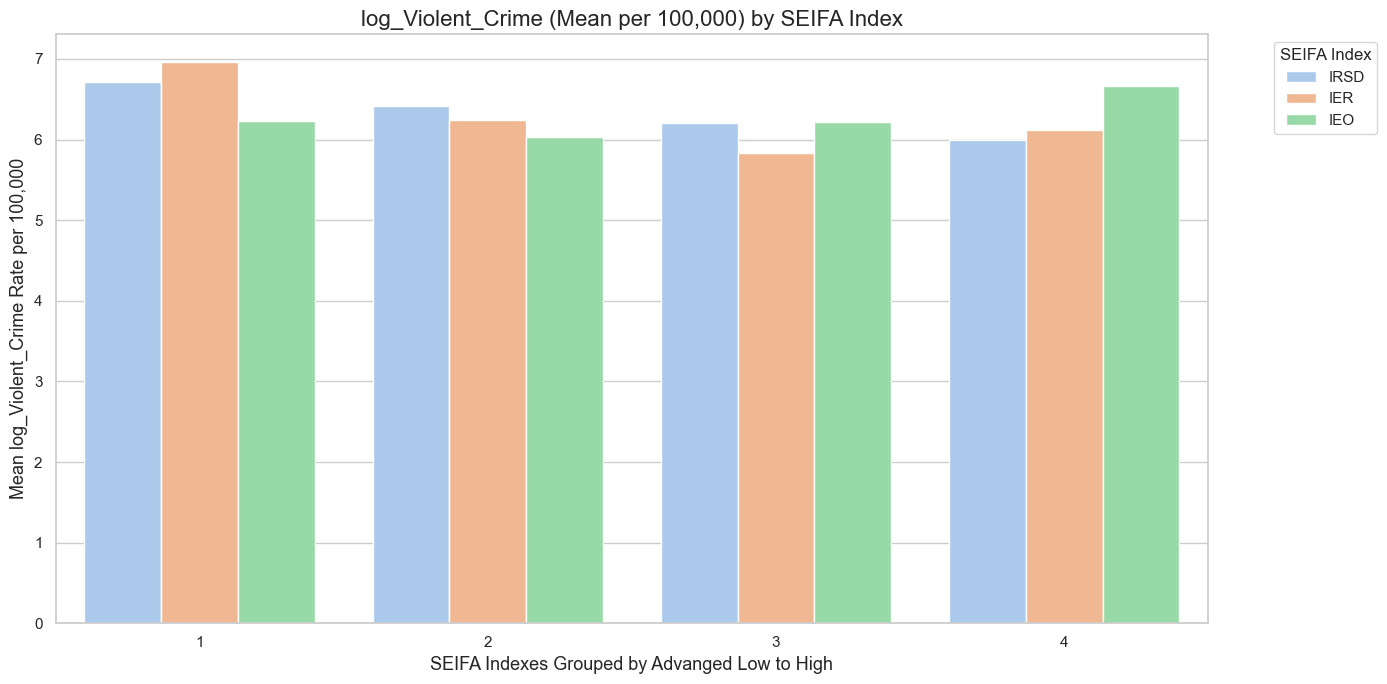

In [12]:
crime_types = ['log_DV_Crime', 'log_Violent_Crime']

# Label mapping
index_labels = {
    'IRSD Group': 'IRSD',
    'IER Group': 'IER',
    'IEO Group': 'IEO'
}

# Plot each crime type
for crime in crime_types:
    # Group and calculate mean
    grouped = df.groupby(['IRSD Group', 'IER Group', 'IEO Group'])[crime].mean().reset_index()

    # Melt to long format
    df_long = pd.melt(
        grouped,
        id_vars=[crime],
        var_name='Index Type',
        value_name='Group'
    )
    df_long['Crime'] = crime
    df_long.rename(columns={crime: 'Mean Value'}, inplace=True)
    df_long['Index Label'] = df_long['Index Type'].map(index_labels)
    df_long['Group'] = df_long['Group'].astype(int)

    # Sort for plotting
    df_long = df_long.sort_values(by='Group')

    # Plot
    plt.figure(figsize=(14, 7))
    barplot = sns.barplot(
        data=df_long,
        x='Group',
        y='Mean Value',
        hue='Index Label',
        palette='pastel',
        errorbar=None
    )
    
    # Title and axes
    plt.title(f'{crime} (Mean per 100,000) by SEIFA Index', fontsize=16)
    plt.xlabel('SEIFA Indexes Grouped by Advanged Low to High', fontsize=13)
    plt.ylabel(f'Mean {crime} Rate per 100,000', fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Move legend outside
    plt.legend(title='SEIFA Index', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)

    plt.tight_layout()
    plt.show()

In [13]:
# grouping the data by the indexes and calculating the log mean for each group
# seems to be a better approach to see the data in a more granular way.
# data seems uniformly distributed across the groups.
# better to run analysis of variance (ANOVA) to see if there is a significant difference between the groups.
# better to run a linear regression model to see the effect of the indexes on the crime rates.

In [14]:

# Select relevant numeric columns
cols_of_interest = ['DV-Related', 'Violent Crime', 'IRSD Score', 'IER Score', 'IEO Score']
corr_matrix = df[cols_of_interest].corr()

# Display the correlation matrix
print(corr_matrix)


               DV-Related  Violent Crime  IRSD Score  IER Score  IEO Score
DV-Related       1.000000       0.940565   -0.477600  -0.510509  -0.134573
Violent Crime    0.940565       1.000000   -0.453444  -0.513460  -0.087658
IRSD Score      -0.477600      -0.453444    1.000000   0.929852   0.718428
IER Score       -0.510509      -0.513460    0.929852   1.000000   0.525754
IEO Score       -0.134573      -0.087658    0.718428   0.525754   1.000000


In [15]:
"""
Variable Pair	Correlation	Interpretation
log_DV_Crime vs IRSD Score	-0.48	Moderate negative correlation – as disadvantage decreases (higher IRSD), DV crime slightly decreases.
log_DV_Crime vs IER Score	-0.51	Similar story – more economic resources = slightly less DV crime.
log_DV_Crime vs IEO Score	-0.16	Very weak negative correlation – education/occupation less associated with DV crime.

The correlation coefficients suggest that there is a moderate to low negative relationship between the SEIFA indexes and DV-related and Violent Crime rates.
he IRSD and IER indexes have a stronger correlation than the IEO index.

"""

'\nVariable Pair\tCorrelation\tInterpretation\nlog_DV_Crime vs IRSD Score\t-0.48\tModerate negative correlation – as disadvantage decreases (higher IRSD), DV crime slightly decreases.\nlog_DV_Crime vs IER Score\t-0.51\tSimilar story – more economic resources = slightly less DV crime.\nlog_DV_Crime vs IEO Score\t-0.16\tVery weak negative correlation – education/occupation less associated with DV crime.\n\nThe correlation coefficients suggest that there is a moderate to low negative relationship between the SEIFA indexes and DV-related and Violent Crime rates.\nhe IRSD and IER indexes have a stronger correlation than the IEO index.\n\n'

In [17]:

crime_vars = ['DV-Related', 'Violent Crime']
seifa_scores = ['IRSD Score', 'IER Score', 'IEO Score']

for crime in crime_vars:
    for seifa in seifa_scores:
        r, p = stats.pearsonr(df[crime], df[seifa])
        print(f"{crime} vs {seifa}: r = {r:.3f}, p = {p:.5f} {'✅' if p < 0.05 else '❌'}")

# The correlation coefficients suggest that there is a moderate to low negative relationship between the SEIFA indexes and DV-related and Violent Crime rates.
# but that they are statistically significant.
# The IRSD and IER indexes have a stronger correlation than the IEO index.

DV-Related vs IRSD Score: r = -0.478, p = 0.00000 ✅
DV-Related vs IER Score: r = -0.511, p = 0.00000 ✅
DV-Related vs IEO Score: r = -0.135, p = 0.03927 ✅
Violent Crime vs IRSD Score: r = -0.453, p = 0.00000 ✅
Violent Crime vs IER Score: r = -0.513, p = 0.00000 ✅
Violent Crime vs IEO Score: r = -0.088, p = 0.18051 ❌


In [ ]:
# even though the correlation coefficients suggest that there is a moderate to low negative relationship between the SEIFA indexes and DV-related and Violent Crime rates,
# it shows that these values are statistically significant due to the low p-values.
# I will run a linear regression model to see the effect of the indexes on the crime rates

# Define the independent variables (SEIFA scores)
X = sm.add_constant(df[['IRSD Score', 'IER Score', 'IEO Score']])
# Response variables (dependent variables)
y_dv = df['log_DV_Crime']
y_vc = df['log_Violent_Crime']
# Model for DV-related crime
model_dv = sm.OLS(y_dv, X).fit()

# Model for Violent crime
model_violent = sm.OLS(y_vc, X).fit()

In [31]:
print("Model for log_DV_Crime")
print(model_dv.summary())

Model for log_DV_Crime
                            OLS Regression Results                            
Dep. Variable:           log_DV_Crime   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     33.29
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           6.38e-18
Time:                        13:47:07   Log-Likelihood:                -283.65
No. Observations:                 235   AIC:                             575.3
Df Residuals:                     231   BIC:                             589.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1769      0.

In [32]:
print("\nModel for log_Violent_Crime")
print(model_violent.summary())



Model for log_Violent_Crime
                            OLS Regression Results                            
Dep. Variable:      log_Violent_Crime   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     39.12
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           1.76e-20
Time:                        13:47:08   Log-Likelihood:                -258.56
No. Observations:                 235   AIC:                             525.1
Df Residuals:                     231   BIC:                             539.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0745  

In [ ]:
# Make predictions
predictions_dv = model_dv.predict(X)  # Predict for DV-related crime
predictions_violent = model_violent.predict(X)  # Predict for Violent Crime

# Compare predictions with actual values (assuming actual values are in 'y')
comparison_dv = pd.DataFrame({'Actual': y_dv, 'Predicted': predictions_dv})
comparison_violent = pd.DataFrame({'Actual': y_vc, 'Predicted': predictions_violent})
# Residuals (errors)
residuals_dv = y_dv - predictions_dv
residuals_violent = y_vc - predictions_violent

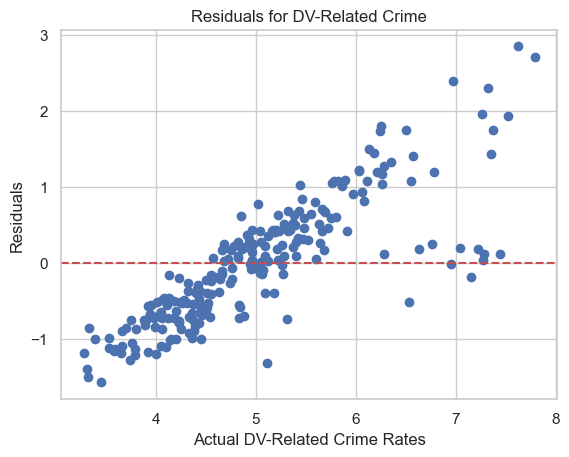

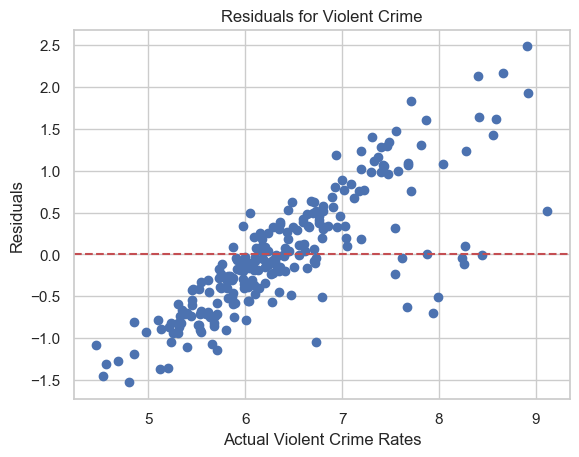

In [38]:

plt.scatter(y_dv, residuals_dv)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for DV-Related Crime')
plt.xlabel('Actual DV-Related Crime Rates')
plt.ylabel('Residuals')
plt.show()

plt.scatter(y_vc, residuals_violent)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Violent Crime')
plt.xlabel('Actual Violent Crime Rates')
plt.ylabel('Residuals')
plt.show()

In [40]:
poly = PolynomialFeatures(degree=2)  # Try degree 2 for quadratic terms
X_poly = poly.fit_transform(X)  # X is your matrix of predictors

In [44]:
# Model for DV-related crime
model_dv = sm.OLS(y1, X_poly).fit()

# Model for Violent crime
model_violent = sm.OLS(y2, X_poly).fit()

In [45]:
print("Model for log_DV_Crime")
print(model_dv.summary())
print("\nModel for log_Violent_Crime")
print(model_violent.summary())

Model for log_DV_Crime
                            OLS Regression Results                            
Dep. Variable:           log_DV_Crime   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     11.66
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           5.38e-15
Time:                        14:09:30   Log-Likelihood:                -280.90
No. Observations:                 235   AIC:                             581.8
Df Residuals:                     225   BIC:                             616.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3657      2.

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


      feature         VIF
0       const  224.453990
1  IRSD Score   15.987278
2   IER Score   10.690703
3   IEO Score    2.991076


In [109]:
X_no_IER = sm.add_constant(df[['IER Score', 'IEO Score']])
vif_data = pd.DataFrame()
vif_data["feature"] = X_no_IER.columns
vif_data["VIF"] = [variance_inflation_factor(X_no_IER.values, i) for i in range(X_no_IER.shape[1])]
print(vif_data)

     feature         VIF
0      const  143.322715
1  IER Score    1.382011
2  IEO Score    1.382011


In [57]:
# Model for DV-related crime
model_dv = sm.OLS(y_dv, X_no_IER).fit()

# Model for Violent crime
model_violent = sm.OLS(y_vc, X_no_IER).fit()

print("Model for log_DV_Crime")
print(model_dv.summary())
print("\nModel for log_Violent_Crime")
print(model_violent.summary())

Model for log_DV_Crime
                            OLS Regression Results                            
Dep. Variable:           log_DV_Crime   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     49.61
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           1.16e-18
Time:                        14:25:53   Log-Likelihood:                -284.03
No. Observations:                 235   AIC:                             574.1
Df Residuals:                     232   BIC:                             584.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7310      0.

In [ ]:
# Make predictions
predictions_dv = model_dv.predict(X_no_IER)  # Predict for DV-related crime
predictions_violent = model_violent.predict(X_no_IER)  # Predict for Violent Crime

# Compare predictions with actual values (assuming actual values are in 'y')
comparison_dv = pd.DataFrame({'Actual': y_dv, 'Predicted': predictions_dv})
comparison_violent = pd.DataFrame({'Actual': y_vc, 'Predicted': predictions_violent})
# Residuals (errors)
residuals_dv = y_dv - predictions_dv
residuals_violent = y_vc - predictions_violent

ValueError: x and y must be the same size

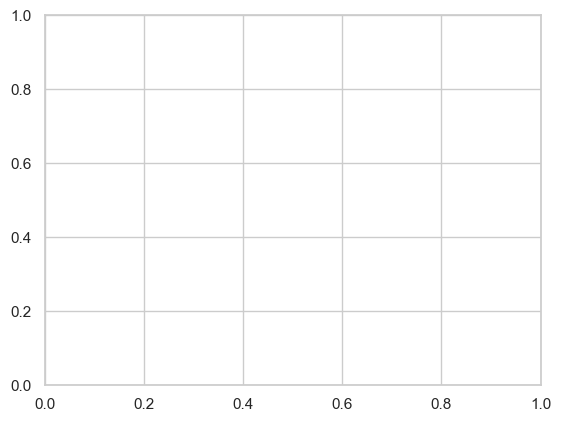

In [141]:
# Display the first few rows of the comparison DataFrame
plt.scatter(X_no_IER, predictions_violent)
# plt.plot([min(y_vc), max(y_vc)], [min(y_vc), max(y_vc)], color='r')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Plot')
# plt.show()
X_no_IER

In [104]:
# Shuffle the data first (very important!)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 80% split index
split_index = int(0.8 * len(df_shuffled))

# Split into training and testing sets
train_df = df_shuffled.iloc[:split_index]
test_df = df_shuffled.iloc[split_index:]


C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\2965475744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['IRSD_sq'] = train_df['IRSD Score'] ** 2
C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\2965475744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['IEO_sq'] = train_df['IEO Score'] ** 2
C:\Users\dsmel\AppData\Local\Temp\ipykernel_27104\2965475744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

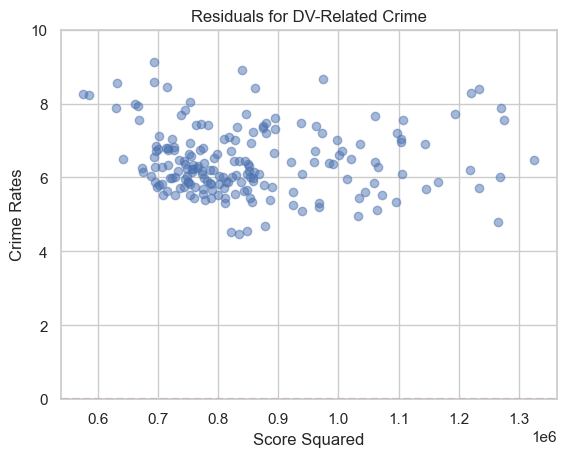

In [112]:
scaler = MinMaxScaler()
#train_df[['IRSD_scaled', 'IEO_scaled', 'IER_scaled']] = scaler.fit_transform(train_df[['IRSD Score', 'IEO Score', 'IER Score']])
train_df['IRSD_sq'] = train_df['IRSD Score'] ** 2
train_df['IEO_sq'] = train_df['IEO Score'] ** 2
train_df['IER_sq'] = train_df['IER Score'] ** 2

plt.scatter(data=train_df, x='IEO_sq', y='log_Violent_Crime', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(0, 10)
plt.title('Residuals for DV-Related Crime')
plt.xlabel('Score Squared')
plt.ylabel('Crime Rates')
plt.show()

In [138]:
# Define the independent variables (SEIFA scores)
X_sq = sm.add_constant(train_df[['IER_sq', 'IEO_sq']])
# Response variables (dependent variables)
y_dv = train_df['log_DV_Crime']
y_vc = train_df['log_Violent_Crime']
# Model for DV-related crime
model_dv = sm.OLS(y_dv, X_sq).fit()

# Model for Violent crime
model_violent = sm.OLS(y_vc, X_sq).fit()

print("Model for log_DV_Crime")
print(model_dv.summary())
print("\nModel for log_Violent_Crime")
print(model_violent.summary())

Model for log_DV_Crime
                            OLS Regression Results                            
Dep. Variable:           log_DV_Crime   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     33.22
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           4.73e-13
Time:                        16:18:05   Log-Likelihood:                -235.65
No. Observations:                 188   AIC:                             477.3
Df Residuals:                     185   BIC:                             487.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7752      0.

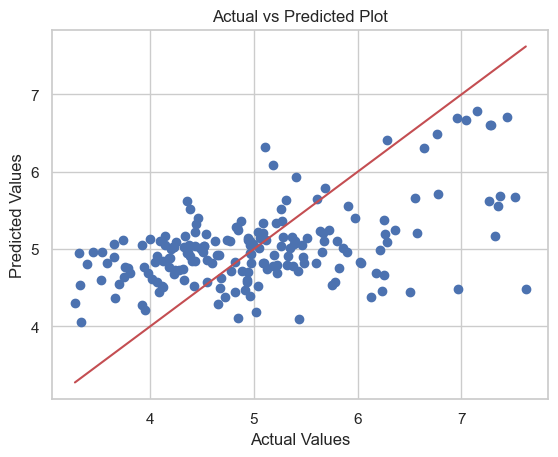

In [135]:
# Make predictions
predictions_dv = model_dv.predict(X_sq)  # Predict for DV-related crime
predictions_violent = model_violent.predict(X_sq)  # Predict for Violent Crime

# Compare predictions with actual values (assuming actual values are in 'y')
comparison_dv = pd.DataFrame({'Actual': y_dv, 'Predicted': predictions_dv})
comparison_violent = pd.DataFrame({'Actual': y_vc, 'Predicted': predictions_violent})
# Residuals (errors)
residuals_dv = y_dv - predictions_dv
residuals_violent = y_vc - predictions_violent

plt.scatter(y_dv, predictions_dv)
plt.plot([min(y_dv), max(y_dv)], [min(y_dv), max(y_dv)], color='r')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Plot')
plt.show()

In [136]:
x = df['your_x_variable'].values.reshape(-1, 1)
y = df['your_y_variable'].values

# Polynomial transformation (degree=2 for a curve)
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)

# Fit polynomial model
model = LinearRegression()
model.fit(x_poly, y)

# Predict across a sorted x range
x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

# Plot
plt.scatter(x, y, alpha=0.5)
plt.plot(x_range, y_pred, color='red', linewidth=2)
plt.title('Scatter Plot with Polynomial Regression Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Model Coefficients:
[ 0.00000000e+00 -4.75237683e-06  1.34765871e-06 -7.66549875e-18
 -4.75237683e-06  1.34765871e-06  1.56332071e-12  4.70028974e-12
 -3.13438598e-12]
Intercept:
8.599954130516812


ValueError: x and y must be the same size

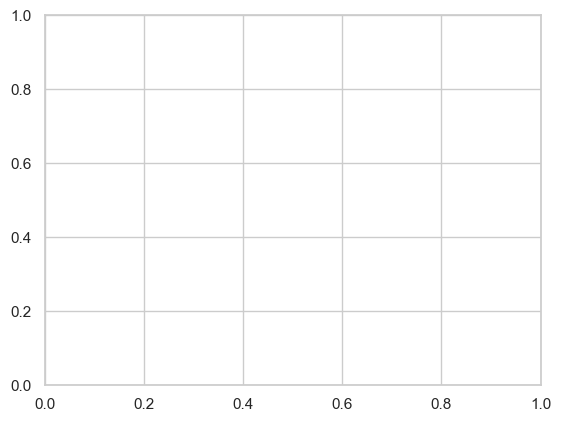

In [139]:

plt.scatter(X_poly, y_pred, alpha=0.5)
plt.plot(X_poly, y_pred, color='red', linewidth=2)
plt.title('Scatter Plot with Polynomial Regression Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [134]:
# Extract coefficients
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_sq)

lin = LinearRegression().fit(X_poly, y_vc)

# See feature names + coefficients
print(poly.get_feature_names_out())
print(lin.coef_)

['const' 'IER_sq' 'IEO_sq' 'const^2' 'const IER_sq' 'const IEO_sq'
 'IER_sq^2' 'IER_sq IEO_sq' 'IEO_sq^2']
[ 0.00000000e+00 -3.36608614e-06  8.37110102e-07 -1.05952280e-17
 -3.36608614e-06  8.37110101e-07  1.42318191e-12  1.55647041e-12
 -7.68090687e-13]
